# Capstone Project: Loan Interest Rates


## Background:
I found this dataset, which is a fintech startup tasked with improving customer loan offers. Using the [🔗Bondora P2P Loans](https://www.kaggle.com/datasets/marcobeyer/bondora-p2p-loans?select=LoanData.csv) dataset, I built insights about what factors help determine a person's interest rate. I created a predictive model to estimate loan interest rates, which will guide in personalizing loan terms efficiently.


The features I've used in this lab are:

- `VerificationType`: Method used for loan application data verification
- `Age`: Age of the borrower (years)
- `AppliedAmount`: Amount applied
- `Amount`: Amount the borrower received
- `Interest`: Interest rate
- `LoanDuration`: The loan term
- `Education`: Education of the borrower
- `EmploymentDurationCurrentEmployer`: Employment time with the current employer
- `HomeOwnershipType`: Home ownership type
- `IncomeTotal`: Total income
- `ExistingLiabilities`: Borrower's number of existing liabilities
- `RefinanceLiabilities`:  The total amount of liabilities after refinancing
- `Rating`: Bondora Rating issued by the Rating model
- `NoOfPreviousLoansBeforeLoan`: Number of previous loans
- `AmountOfPreviousLoansBeforeLoan`: Value of previous loans


## Table of Contents
- [Step 1: Importing Libraries](#step-1)
- [Step 2: Load and Clean the Data](#step-2)
    - [Load the data](#load-the-data)
    - [Cleaning the Dataset](#cleaning-the-dataset)
        - [Exercise 1: Set Index](#ex1)
- [Step 3: Retrieving Key Metrics](#step-3)
    - [Describing the Dataset](#describing-the-dataset)
        - [Exercise 2: Descriptive Statistics](#ex2)
    - [High-Risk Customers](#high-risk-customers)
        - [Exercise 3: Identifying High-Risk customers](#ex3)
- [Step 4: Understanding different customer profiles](#step-4)
    - [Visualization of Different Profiles](#visualization-of-different-profiles)
        - [Exercise 4: Segmentation Using Box Plots](#ex4)
        - [Exercise 5: Scatter Plots and Correlation](#ex5)
    - [Applied and Received Amounts](#applied-and-received-amounts)
        - [Exercise 6: Confidence Intervals](#ex6)
- [Step 5: Modelling the Interest Rate](#step-5)
    - [Simple Linear Regression](#categorical-features)
        - [Exercise 7: Training the Linear Regression](#ex7)
    - [Building a More Complex Linear Regression Model](#building-the-linear-regression-model)
        - [Exercise 8: Building and Refining the Model](#ex8)

<a id="step-1"></a>

## Step 1: Importing libraries

Before we start working on the dataset, it is good practice to import all libraries at the beginning of our code. 



In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from math import sqrt

<a id="step-2"></a>

## Step 2: Load and Clean the Data

<a id="load-the-data"></a>

### Load the Data
Now that we have imported the right libraries, we can use Pandas to load the data from the CSV. 
Then we'll set Loan ID as the index



In [6]:
# load the data
df = pd.read_csv("LoanData.csv")
df.head(1)

,LoanId,NewCreditCustomer,LoanDate,VerificationType,Age,Gender,Country,AppliedAmount,Amount,Interest,...,EmploymentDurationCurrentEmployer,HomeOwnershipType,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,Rating,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan
0,D8EBF360-104C-420F-BEC9-000924E6EFC7,False,2022-09-09,By Bank Statement,27,Female,EE,3189.0,3189.0,35.48,...,UpTo5Years,Other,900.0,0,0.0,0,D,1.0,3402.0,0.0


In [7]:

# set the "LoanId" column as index
df.set_index("LoanId", inplace = True)
# check the index is correct
df.index.name

'LoanId'

<a id="step-3"></a>

## Step 3: Retrieving key metrics
To recommend loan offers, we'll take a moment to understand the loan amounts and ratings. we’ll also want to get a rough idea of the interest rates being paid.

<a id="describing-the-dataset"></a>

### Describing the dataset 

<a id="ex2"></a>

#### Exercise 2: descriptive statistics

In [8]:
# find the sample mean and std of the "Interest" column
interest_mean = df["Interest"].mean()
interest_std = df["Interest"].std()

# find the number of borrowers that received a smaller "Amount" than they asked for ("AppliedAmount")
num_less_amount = (df["AppliedAmount"] > df["Amount"]).sum()

# find the proportion of loan ratings
rating_proportion = df["Rating"].value_counts()/len(df)


# print the results
print("Interest rate mean:", round(interest_mean, 2))
print("Interest rate standard deviation:", round(interest_std,2))
print("Number of borrowers that received less money than they asked for:", num_less_amount)
print("Proportion of loan ratings:\n", rating_proportion.sort_index())

Interest rate mean: 27.29
Interest rate standard deviation: 18.03
Number of borrowers that received less money than they asked for: 10543
Proportion of loan ratings:
 Rating
A     0.043291
AA    0.024826
B     0.179124
C     0.317741
D     0.206457
E     0.115707
F     0.074443
HR    0.038411
Name: count, dtype: float64


<a id="high-risk-customers"></a>

### High-Risk Customers

Customers with a high debt-to-income ratio and less job stability may have more difficulty repaying loans, making them riskier.

<a id="ex3"></a>

#### Exercise 3: Identifying High-Risk Customers
We want to identify these customers and be able to add a flag to their loans. We should consider borrowers to have less job stability if they have been in their current job for less than 1 year (including those in the trial period). In this scenario, a loan-to-rate ratio above 0.35 is considered risky.


In [9]:
# create the column "DebtToIncome" 
df["DebtToIncome"] = df["Amount"]/df["IncomeTotal"]

# create a new column "IsRisky" that is True if the loan is risky
df["IsRisky"] = (df["DebtToIncome"] >= 0.35) & ((df["EmploymentDurationCurrentEmployer"] == "UpTo1Year") |(df["EmploymentDurationCurrentEmployer"] == "TrialPeriod"))

# Calculate the proportion of risky loans
risky_proportion = df["IsRisky"].mean()

# Calculate the mean interest rate of the risky loans
mean_interest_risky = df.loc[df["IsRisky"] == True, "Interest"].mean()

# Calculate the mean interest rate of the non-risky loans
mean_interest_non_risky = df.loc[df["IsRisky"] == False, "Interest"].mean()

# print the results
print("Risky loans proportion:", round(risky_proportion, 4))
print("Mean interest rate of risky loans:", round(mean_interest_risky, 4))
print("Mean interest rate of non-risky loans:", round(mean_interest_non_risky, 4))


Risky loans proportion: 0.1588
Mean interest rate of risky loans: 28.8592
Mean interest rate of non-risky loans: 26.9899


<a id="step-4"></a>

## Step 4: Understanding different customer profiles

As a fintech analyst, understanding customer profiles allows you to identify patterns. Now we want to understand how different factors of the borrowers influence loan applications. 

<a id="visualization-of-different-profiles"></a>

### Visualization of different profiles

To help us identify the different profiles, I decided to use my visualization skills to uncover actionable patterns for tailoring loan offers.

<a id="ex4"></a>
#### Exercise 4: Segmentation using box plots

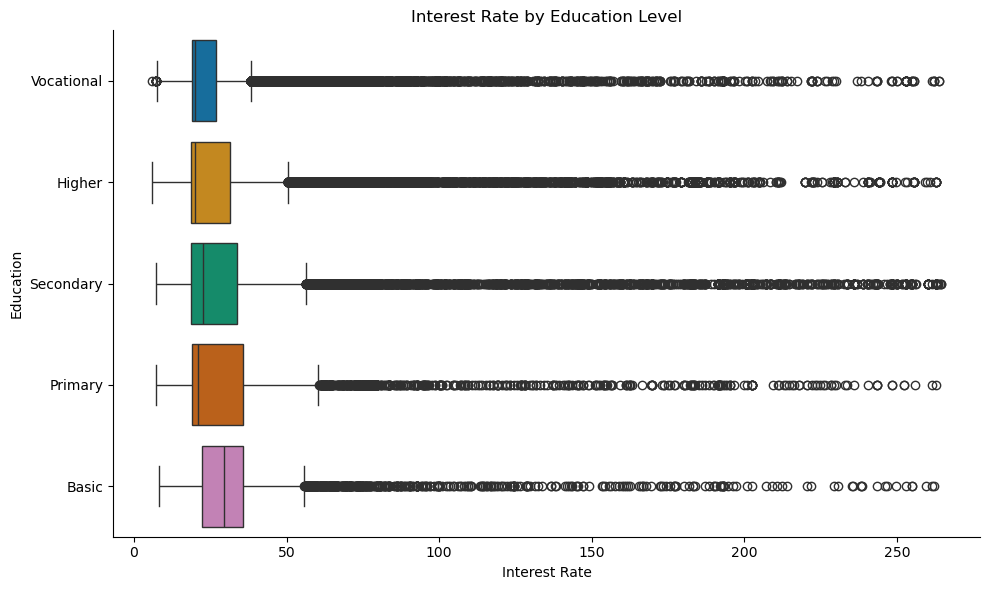

In [10]:

# create the figure with size (10,6)
plt.figure(figsize=(10,6))

# create the interest rate by segmentation plot
boxplot_ax = sns.boxplot(df, x="Interest", y="Education",hue="Education",palette="colorblind")

# set the x-axis label
plt.xlabel("Interest Rate")

# set the title
plt.title("Interest Rate by Education Level")

# despine the plot
sns.despine()

plt.tight_layout()
plt.show()

<a id="ex5"></a>

#### Exercise 5: Scatter plots and correlation
We should also investigate the relationship between certain numerical features and the interest rate. For that, I decided to use scatter plots, along with the correlation between features.
.

Correlation between Interest Rate and AmountOfPreviousLoansBeforeLoan:
-0.175
Correlation between Interest Rate and DebtToIncome:
-0.0053


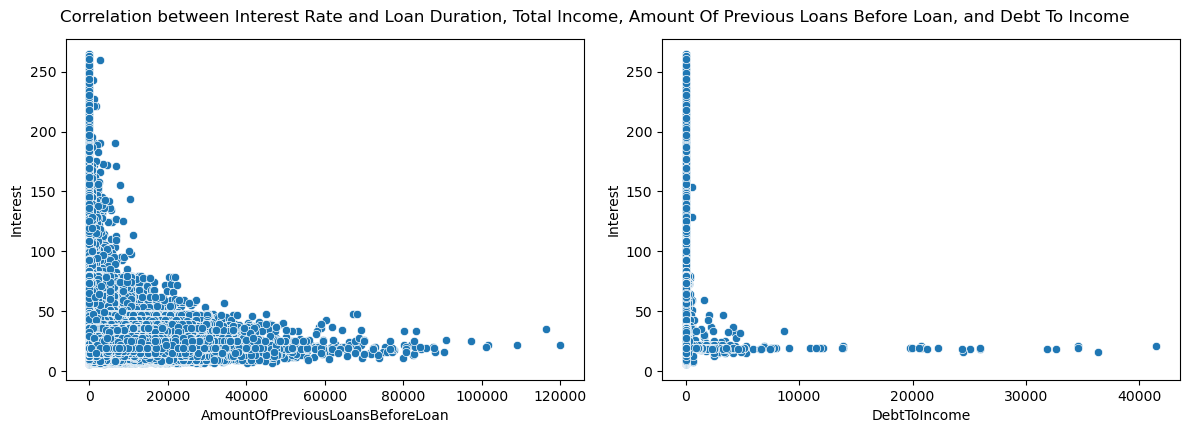

In [11]:
scatterplot_fig = plt.figure(figsize=(12, 8))

# create a list to store the correlation values
correlation = []

# create a list of segmentation columns
corr_columns = ["AmountOfPreviousLoansBeforeLoan", 
               "DebtToIncome"]

# set the general title
plt.suptitle("Correlation between Interest Rate and Loan Duration, Total Income, Amount Of Previous Loans Before Loan, and Debt To Income")
# iterate over the values 1-4 (one for each subplot)
for i in range(len(corr_columns)):

    # get the column name. Remember subtract 1 from i to match the list's indexing
    column_name = corr_columns[i]

    # create the subplot. Remember the arguments are (rows, columns, index)
    plt.subplot(2,2,i+1)
    # create scatter plot
    sns.scatterplot(df, x=df[column_name], y=df["Interest"])

    # calculate the correlation between the column and the interest rate
    corr = df[column_name].corr(df["Interest"])
    # append the correlation value to the list
    correlation.append(i)
    # print the results
    print("Correlation between Interest Rate and " + column_name+ ":\n"+ str(round(corr,4))) 
    
plt.tight_layout()
plt.show()

<a id="applied-and-received-amounts"></a>

### Applied and Received Amounts
I noticed that there are two similar columns, "AppliedAmount" and "Amount", in the dataset. This implies that sometimes borrowers get a loan for a different amount than what they asked for. 

<a id="ex6"></a>

#### Exercise 6: Confidence Intervals

If more than 5% of loans are approved for less than requested, the team may need to revise how loan amounts are communicated to applicants. Estimate this proportion using a confidence interval to support your recommendation.


In [12]:
# get the number of samples where "AppliedAmount" differs from the requested
# "Amount"
num_differences = (df["Amount"] < df["AppliedAmount"]).sum()

# get the total number of samples
n = len(df)

# calculate the sample proportion
phat = num_differences/n
import math
# calculate the standard error for proportions
se = math.sqrt(phat*(1-phat)/n)

# build the confidence interval
confidence_interval = stats.norm.interval(0.95,loc=phat,scale=se)

# print the results
print("The 95% confidence interval is", confidence_interval)

The 95% confidence interval is (0.02698232853687249, 0.028017645379482474)


The proportion of loans where the requested amount differs from the given amount is pretty small, so it should be safe to only analyze one of those columns.

<a id="step-5"></a>

## Step 5: Modelling the Interest Rate
To make personalized loan offers, I decided to go one step further in my analysis and build a model to predict interest rates using different customer features. This will help us both be able to predict interest rates for new customers, and observe which features are actually statistically significant in determining the interest rates. 

<a id="categorical-features"></a>

### Simple Linear Regression

To get our first model going, we begin by creating a simple linear regression. Based on the correlation analysis we did before, a good candidate for the independent variable is "AmountOfPreviousLoansBeforeLoan", which presented the strongest correlation with the target variable "Interest". 

<a id="ex7"></a>

#### Exercise 7: Training the Linear Regression


In [13]:

# prepare predictors. do not forget to add the constant term
X_simple = sm.add_constant(df["AmountOfPreviousLoansBeforeLoan"])

# select the dependent variable
Y_simple = df["Interest"]

# build the model
model_simple = sm.OLS(Y_simple,X_simple)

# fit the model
results_simple = model_simple.fit()

# Print the results summary
print(results_simple.summary())

                            OLS Regression Results                            
Dep. Variable:               Interest   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                 1.211e+04
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:54:42   Log-Likelihood:            -1.6468e+06
No. Observations:              383382   AIC:                         3.294e+06
Df Residuals:                  383380   BIC:                         3.294e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

<a id="building-the-linear-regression-model"></a>

### Building a More Complex Linear Regression Model

Since predicting the interest rate using a single variable didn’t yield strong results, I decided to take a more comprehensive approach. This time, we’ll build a more complex model that includes multiple variables—possibly even some categorical ones.

**Reflect**: which variables would you use as predictors?

<a id="ex8"></a>

#### Exercise 8: Building and refining the model
This time, we will make the decision on which variables to use. Iterate until we are satisfied with the result. If you need to write any additional code, you can add a new cell by clicking on the $+$ button, and work there. 


**My goal is to make our model achieve an R-squared greater than 0.6, and all the included variables need to be statistically significant (p-value < 0.05)**

In [14]:

# define a list with the column names we want to use as predictors
# include numerical and categorical variables

# Testing variables
# ,"IncomeTotal"
# ,"PreviousEarlyRepaymentsCountBeforeLoan"
#,"DebtToIncome"

# All the cetegorical varibles I decided to use, and then converted to numerical using get_dummies from pandas
categorical = ["Rating", "NewCreditCustomer","VerificationType","Education","EmploymentDurationCurrentEmployer"]

df_encoded = pd.get_dummies(df, columns=categorical, drop_first=True, dtype = int)

predictors = ["LoanDuration","AmountOfPreviousLoansBeforeLoan",
              "AppliedAmount","ExistingLiabilities","NoOfPreviousLoansBeforeLoan"] + \
             [col for col in df_encoded.columns if any(var in col for var in categorical)]

# create the predictors dataframe. do not forget to add the constant term
X = sm.add_constant(df_encoded[predictors])
# create the target variable
Y = df_encoded["Interest"]
# create the model
model = sm.OLS(Y,X)

# fit the model
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Interest   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                 2.167e+04
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:01:10   Log-Likelihood:            -1.4709e+06
No. Observations:              383382   AIC:                         2.942e+06
Df Residuals:                  383353   BIC:                         2.942e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------